In [1]:
import apogee.tools.read as apread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/pkg_resources.py:1054: UserWarning: /home/price-jones/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
data = apread.rcsample()

In [3]:
def get_spectra(data):
    """
    Returns spectra and header information for each object specified in data
    
    data:    labels for a subset of the APOGEE survey
    """
    specs = []
    hdrs = []
    for i in range(len(data)):
        spec,hdr = apread.aspcapStar(data['LOCATION_ID'][i],data['APOGEE_ID'][i],aspcapWavegrid=True)
        specs.append(spec)
        hdrs.append(hdr)
    return np.array(specs),np.array(hdrs)

def makematrix(x,order):
    if isinstance(x,tuple):
        nindeps = len(x)
        X = np.empty((len(x[0]),order*nindeps+1))
        X[:,0] = x[0]**0
        i = 1
        while i < order*nindeps+1:
            for o in range(1,order+1):
                for n in range(nindeps):
                    X[:,i] = x[n]**o
                    i+=1
    elif isinstance(x,(list,np.ndarray)):
        X = np.empty((len(x),order+1))
        for o in range(order+1):
            X[:,o] = x**o
    X = np.matrix(X)
    return X

def regfit(x,y,order = 1):
    """
    Fits a (nD-)polynomial of specified order with independent values given in x,
    given dependent values in y.
    
    x:       array of independent variable 
            (may be tuple containing arrays of multiple variables)   
    y:       array of dependent variable (must have same shape as array in x)
    order:   order of polynomial to fit (kwarg, default = 1)
    
    Returns the polynomial coefficents ascending from 0th order. In the case of
    multiple independent variables, returns coefficients at each polynomial order
    in order of the variables listed in x.
    """
    X = makematrix(x,order)
    return np.array(np.linalg.inv(X.T*X)*X.T*np.matrix(y).T)

def poly(p,x,order = 1):
    """
    For a given set of polynomial coefficients ascending from
    0th order, and a independent variables, returns polynomial.
    """
    if isinstance(x,tuple):
        nindeps = len(x)
        order = (len(p)-1)/nindeps
        y = np.zeros(x[0].shape)
        y += p[0]*x[0]**0
        i = 1
        while i < order*nindeps+1:
            for o in range(1,order+1):
                for n in range(nindeps):
                    y+=p[i]*x[n]**o
                    i+=1
    elif isinstance(x,(list,np.ndarray)):
        order = len(p)-1
        y = np.zeros(x.shape)
        o = 0
        while o <= order:
            y += p[o]*x**o
            o += 1
    return y
        

In [4]:
# Basic function testing
x = np.arange(2,5,0.01)
c = np.log(np.copy(x))
y = np.copy(x)**3+c**2+9
ptest = regfit((x,c),y,order = 3)

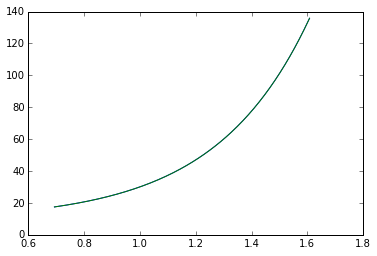

In [5]:
# Basic function testing
plt.plot(c,y)
plt.plot(c,poly(ptest,(x,c),order = 3))

In [14]:
def slice_data(data,sliceinfo):
    label, lower, upper = sliceinfo
    indx = (data[label]>lower) & (data[label]<upper)
    data = data[indx]
    return data

In [7]:
data = slice_data(data,['METALS',0.45,0.5])
specs,hdrs = get_spectra(data)
p = regfit((data['TEFF'],data['LOGG']),specs[:,6296],order = 1)
p

array([[-0.15339001],
       [ 0.00016346],
       [-0.02045503]])

In [8]:
Teff = np.arange(min(data['TEFF']),max(data['TEFF']))
logg = np.arange(min(data['LOGG']),max(data['LOGG']),((max(data['LOGG']-min(data['LOGG'])))/len(Teff)))
len(logg)

920

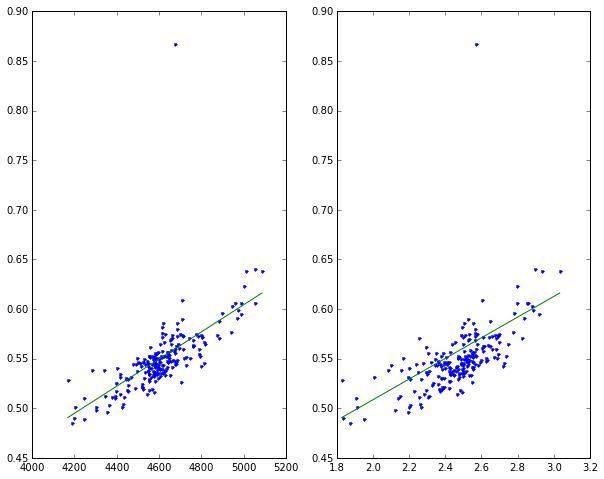

In [9]:
plt.figure(figsize = (10,8))
plt.subplot(121)
plt.plot(data['TEFF'],specs[:,6296],'.')
plt.plot(Teff,poly(p,(Teff,logg)))
plt.subplot(122)
plt.plot(data['LOGG'],specs[:,6296],'.')
plt.plot(logg,poly(p,(Teff,logg)))

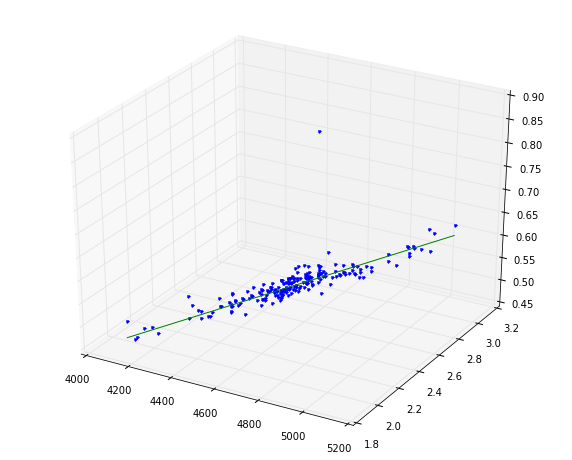

In [13]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data['TEFF'],data['LOGG'],specs[:,6296],'.')
ax.plot(Teff,logg,poly(p,(Teff,logg)))